# Computational biology FFR110 - 2024

# Assignment 2 - Problem 2: Diffusion driven instability

# Fredrik Sitje, Felix Waldschock


In [145]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import scienceplots
plt.style.use('science')
import scipy 

In [146]:
# Parameters
L = 128 # length of the space domain
a = 3
b = 8
Du = 1
Dv = [2.3, 3, 5, 9]

# Steady state solution
us = a
vs = b/a

print(f"Steady state solution: u = {us}, v = {vs}")

# Simulation parameters
dt = 0.01
N = 1000        # number of iterations



Steady state solution: u = 3, v = 2.6666666666666665


In [147]:
def initHabitat(size, steadyStateValue):
    # add padding to the habitat for the boundary conditions
    size = size + 2
    habitat = np.ones((size,size))
    habitat = habitat * steadyStateValue
    # add a small perturbation to the habitat
    for i in range(1, size-1):
        for j in range(1, size-1):
            habitat[i,j] += habitat[i,j] * np.random.rand() * 0.1 

    # set the boundary conditions to zero
    # habitat[0,:] = 0
    # habitat[-1,:] = 0
    # habitat[:,0] = 0
    # habitat[:,-1] = 0

    return habitat



In [148]:
U_Conentration = initHabitat(L, us)
V_Conentration = initHabitat(L, vs)

$\frac{\partial u}{\partial t}=a-(b+1)u+u^{2}v+D_{u}\nabla^{2}u\,,$

${\frac{\partial v}{\partial t}}=b u-u^{2}v+D_{v}\nabla^{2}v\,.$


In [149]:

def updateHabitats(U_Concentration, V_Concentration, Dv):
    U_Concentration_old = U_Concentration.copy()
    V_Concentration_old = V_Concentration.copy()

    laplacian_U = U_Concentration_old[:-2, 1:-1] + U_Concentration_old[2:, 1:-1] + U_Concentration_old[1:-1, :-2] + U_Concentration_old[1:-1, 2:] - 4 * U_Concentration_old[1:-1, 1:-1]
    laplacian_V = V_Concentration_old[:-2, 1:-1] + V_Concentration_old[2:, 1:-1] + V_Concentration_old[1:-1, :-2] + V_Concentration_old[1:-1, 2:] - 4 * V_Concentration_old[1:-1, 1:-1]

    dU = a - (b + 1) * U_Concentration_old[1:-1, 1:-1] + U_Concentration_old[1:-1, 1:-1]**2 * V_Concentration_old[1:-1, 1:-1] + Du * laplacian_U
    dV = b * U_Concentration_old[1:-1, 1:-1] - U_Concentration_old[1:-1, 1:-1]**2 * V_Concentration_old[1:-1, 1:-1] + Dv * laplacian_V

    # set the top row to the second row
    U_Concentration[0, :] = U_Concentration[1, :]
    V_Concentration[0, :] = V_Concentration[1, :]
    # set the bottom row to the second last row
    U_Concentration[-1, :] = U_Concentration[-2, :]
    V_Concentration[-1, :] = V_Concentration[-2, :]
    # set the left column to the second column
    U_Concentration[:, 0] = U_Concentration[:, 1]
    V_Concentration[:, 0] = V_Concentration[:, 1]
    # set the right column to the second last column
    U_Concentration[:, -1] = U_Concentration[:, -2]
    V_Concentration[:, -1] = V_Concentration[:, -2]
    
    U_Concentration[1:-1, 1:-1] = U_Concentration_old[1:-1, 1:-1] + dt * dU
    V_Concentration[1:-1, 1:-1] = V_Concentration_old[1:-1, 1:-1] + dt * dV


    return U_Concentration, V_Concentration, False


In [150]:
# create a Class to store the results
class Results:
    def __init__(self, U_Concentration, V_Concentration, ininitalU, ininitalV, U_Concentration_steadyState, V_Concentration_steadyState, counter):
        self.U_Concentration = U_Concentration
        self.V_Concentration = V_Concentration
        self.DV = 0
        self.ininitalU = ininitalU
        self.ininitalV = ininitalV
        self.spatialSteadyState_U = U_Concentration_steadyState
        self.spatialSteadyState_V = V_Concentration_steadyState
        self.counterToSteadyState = counter

In [151]:
# Run the simulation
ListOfResults = []
tolerance = 0.001
for DV in Dv:
    steadyStateReached = False
    counter = 0
    # initialize the habitats
    U_Concentration = initHabitat(L, us)
    V_Concentration = initHabitat(L, vs)
    ininitalU = U_Concentration.copy()  
    ininitalV = V_Concentration.copy()  
    for i in trange(N):
        # check if steady state is reached
        U_Concentration_copy = U_Concentration.copy()
        V_Concentration_copy = V_Concentration.copy()
        U_Concentration, V_Concentration, done = updateHabitats(U_Concentration, V_Concentration, DV)
        counter += 1
        # if change of every element in the matrix is less than tolerance, then break
        if np.all(np.abs(U_Concentration - U_Concentration_copy) < tolerance) and np.all(np.abs(V_Concentration - V_Concentration_copy) < tolerance):
            print(f"Steady state reached after {i} iterations")
            steadyStateReached = True
            break
        
    U_Concentration_N = U_Concentration.copy()
    V_Concentration_N = V_Concentration.copy()

    # continue the simulation to reach the spatially homogenenous steady state
    if not steadyStateReached:
        for i in trange(N*15):
            U_Concentration_copy = U_Concentration.copy()
            V_Concentration_copy = V_Concentration.copy()
            U_Concentration, V_Concentration, done = updateHabitats(U_Concentration, V_Concentration, DV)
            counter += 1
            # if change of every element in the matrix is less than tolerance, then break
            if np.all(np.abs(U_Concentration - U_Concentration_copy) < tolerance) and np.all(np.abs(V_Concentration - V_Concentration_copy) < tolerance):
                print(f"Steady state reached after {i} iterations")
                break
    
    # store the results
    results = Results(U_Concentration_N, V_Concentration_N, ininitalU, ininitalV, U_Concentration, V_Concentration, counter)  # Use copy() method to create a deep copy
 

    results.DV = DV
    
    # undo the padding 
    ListOfResults.append(results)



 26%|██▌       | 258/1000 [00:00<00:00, 1845.68it/s]


Steady state reached after 258 iterations


 26%|██▌       | 261/1000 [00:00<00:00, 2820.07it/s]


Steady state reached after 261 iterations


 79%|███████▉  | 11904/15000 [00:04<00:01, 2751.75it/s]


Steady state reached after 11904 iterations


 55%|█████▍    | 8248/15000 [00:03<00:02, 2614.63it/s]

Steady state reached after 8248 iterations


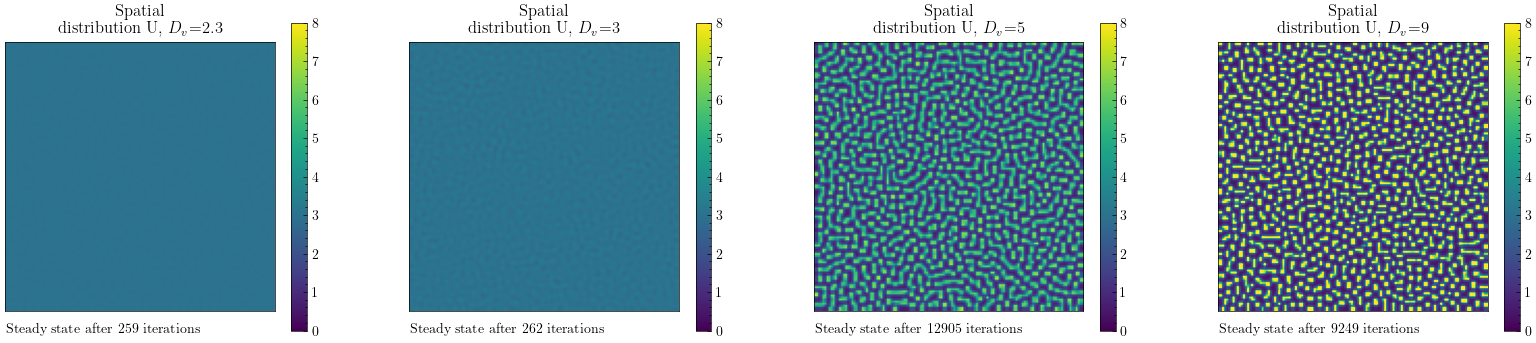

In [152]:
# define color map
cmap = plt.get_cmap('viridis')
# fix the color range
vmin = 0
vmax = 8


fig, axs = plt.subplots(1, len(ListOfResults), figsize=(20,10))

for i, result in enumerate(ListOfResults):

    # plot the final concentration of U
    im = axs[i].imshow(result.U_Concentration, cmap=cmap, vmin=vmin, vmax=vmax)
    #im = axs[i].imshow(result.U_Concentration, cmap=cmap)
    axs[i].set_title(f'Spatial\ndistribution U, $D_v$={result.DV}')
    
    axs[i].text(0,140,f"Steady state after {result.counterToSteadyState} iterations")

    # add color bar
    fig.colorbar(im, ax=axs[i], shrink=0.4)
    # axis no ticks
    axs[i].set_xticks([])
    axs[i].set_yticks([])

# save the figure as a .eps
plt.savefig('1-2_reaction_diffusion.eps', format='eps')
